In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch as T
from tqdm import tqdm



In [ ]:
boardSize = (10,10)   # Legt die Größe des Feldes fest
timeSteps = 20 # Legt die Spieldauer fest (Anz. Iterationen)
safeDist = 2
netScaler = 1
Layer1 = int(128*netScaler)
Layer2 = int(256*netScaler)
Layer3 = int(128*netScaler)

In [ ]:
def showhist(hist):
        for i in range(len(hist)):
            h = hist[i].astype(np.int)
            m = np.ones(boardSize)


            m[h[4], h[5]] = 0.9 
            m[h[6], h[7]] = 0.9
            m[h[8], h[9]] = 0.9
            m[h[10], h[11]] = 0.9
            m[h[12], h[13]] = 0.9
            m[h[14], h[15]] = 0.9
            m[h[16], h[17]] = 0.9

            #for j in range(0,7):
            #    m[h[4+j],h[4+j+1]] = 0.9
            m[h[0],h[1]] = 0
            m[h[2],h[3]] = 0.5
            print("Player: (" + str(h[0]) +"," + str(h[1]) + "), Aim: (" + str(h[2]) + "," + str(h[3]) +") ")
            plt.imshow(m, cmap='hot', interpolation='nearest')
            plt.show()
            
def showReward(h):
    obstacles = [obstacle(7,5),
                 obstacle(5,5),
                 obstacle(3,5),
                 obstacle(7,4),
                 obstacle(6,6),
                 obstacle(6,5),
                 obstacle(6,4)
    ]
    m = np.zeros(boardSize)
    for i in range(boardSize[0]):
        for j in range(boardSize[1]):
            m[i,j] , _= env.getRewardForField(i,j)
            #m[8,8] = 100
    return m.astype(np.int)




In [42]:
class DeepQNetwork(nn.Module):
    def __init__(self, ALPHA, input_dims, fc1_dims, fc2_dims, fc3_dims,
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.fc3_dims = fc3_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc2s = nn.Linear(self.fc2_dims, self.fc3_dims)
        self.fc3 = nn.Linear(self.fc3_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=ALPHA)
        #self.optimizer = optim.SGD(self.parameters(), lr=ALPHA, momentum=0.5)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, observation):
        state = T.Tensor(observation).to(self.device)
        #observation = observation.view(-1)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2s(x))
        actions = self.fc3(x)
        return actions

In [43]:
# Classes

class player:
    def __init__(self,gamma,epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=10000, eps_end = 0.01, eps_dec=5e-6):
        #self.x = x
        #self.y = y
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.mem_size = max_mem_size
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        self.mem_cntr = 0
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims,
                                  fc1_dims=Layer1, fc2_dims=Layer2,fc3_dims=Layer3)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions),
                                      dtype=np.uint8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)
        
    def storeTransition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1

    def chooseAction(self, observation):
        rand = np.random.random()
        actions = self.Q_eval.forward(observation)
        if rand > self.epsilon:
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
        
    def changeLR(self, lr):
        self.lr = lr
        
    def learn(self):
        if self.mem_cntr > self.batch_size:
            self.Q_eval.optimizer.zero_grad()

            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size \
                                    else self.mem_size

            batch = np.random.choice(max_mem, self.batch_size)
            state_batch = self.state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.int32)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            reward_batch = T.Tensor(reward_batch).to(self.Q_eval.device)
            terminal_batch = T.Tensor(terminal_batch).to(self.Q_eval.device)

            q_eval = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            #q_target = self.Q_eval.forward(state_batch).to(self.Q_eval.device)
            q_target = q_eval.clone()
            q_next = self.Q_eval.forward(new_state_batch).to(self.Q_eval.device)

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = reward_batch + \
                                self.gamma*T.max(q_next, dim=1)[0]*terminal_batch

            self.epsilon = self.epsilon*self.eps_dec if self.epsilon > \
                           self.eps_end else self.eps_end

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()
        
    #def move(self,dir):         # Wir können später gerne noch diagonale Bewegungen hinzufügen
    #    if dir == "up":
    #        if self.y +1 < boardSize[1]:
    #            self.y +=1
    #    if dir == "down":
    #        if self.y -1 >= 0:
    #            self.y -=1
    #    if dir == "right":
    #        if self.x +1 < boardSize[0]:
    #            self.x +=1
    #    if dir == "left":
    #        if self.y -1 >= 0:
    #            self.x -=1
                
            
      
    
    
    
    
    
class aim:
    def __init__(self,x,y):
        self.x = x
        self.y = y        
        
        
class obstacle:
    def __init__(self,x,y):
        self.x = x
        self.y = y 

In [44]:
class game:
    def __init__(self,startPos, aimPos ,boardSize = (10,10)):
        self.startPos = np.copy(startPos)
        self.playerPos = startPos
        self.aim = aim(aimPos[0],aimPos[1])
        self.boardSize = boardSize
        self.reward = 0
        self.obstacles = [obstacle(7,5),
                          obstacle(5,5),
                          obstacle(3,5),
                          obstacle(7,4),
                          obstacle(6,6),
                          obstacle(6,5),
                          obstacle(6,4)
    ]
        
        
    def reset(self):
        self.playerPos = self.startPos
        #print(self.startPos)
        #print(self.playerPos)
        self.reward = 0
        observ = np.zeros(18)
        
        observ[0] = self.playerPos[0]
        observ[1] = self.playerPos[1]
        observ[2] = self.aim.x
        observ[3] = self.aim.y
        observ[4] = self.obstacles[0].x
        observ[5] = self.obstacles[0].y
        observ[6] = self.obstacles[1].x
        observ[7] = self.obstacles[1].y
        observ[8] = self.obstacles[2].x
        observ[9] = self.obstacles[2].y
        observ[10] = self.obstacles[3].x
        observ[11] = self.obstacles[3].y
        observ[12] = self.obstacles[4].x
        observ[13] = self.obstacles[4].y
        observ[14] = self.obstacles[5].x
        observ[15] = self.obstacles[5].y
        observ[16] = self.obstacles[6].x
        observ[17] = self.obstacles[6].y

        
        #print(observ)
        return observ
        
        
    def step(self, action):
        done = False
        
        if(action==0):
            self.playerPos[0] +=1
        if(action==1):
            self.playerPos[0] -=1
        if(action==2):
            self.playerPos[1] +=1
        if(action==3):
            self.playerPos[1] -=1
        
        #print(self.startPos)
        observ = np.zeros(18)
        
        observ[0] = self.playerPos[0]
        observ[1] = self.playerPos[1]
        observ[2] = self.aim.x
        observ[3] = self.aim.y
        observ[4] = self.obstacles[0].x
        observ[5] = self.obstacles[0].y
        observ[6] = self.obstacles[1].x
        observ[7] = self.obstacles[1].y
        observ[8] = self.obstacles[2].x
        observ[9] = self.obstacles[2].y
        observ[10] = self.obstacles[3].x
        observ[11] = self.obstacles[3].y
        observ[12] = self.obstacles[4].x
        observ[13] = self.obstacles[4].y
        observ[14] = self.obstacles[5].x
        observ[15] = self.obstacles[5].y
        observ[16] = self.obstacles[6].x
        observ[17] = self.obstacles[6].y

        
        
        reward, done = self.getRewardForField(self.playerPos[0],self.playerPos[1])
        
        return observ, reward, done
            
            
    def createMap(self,plot=False):
        
        m = np.ones(self.boardSize)
        m[self.playerPos[0],self.playerPos[1]] = 0
        m[self.aim.x,self.aim.y] = 0.5
        for ob in self.obstacles:
            m[ob.x,ob.y] = 0.9
        if plot:
            plt.imshow(m, cmap='hot', interpolation='nearest')
            plt.show()
        else:
            return m
    
    def checkBounds(self,p):
        if(p[0]<0):
            return -100, True
        if(p[1]<0):
            return -100, True
        if(p[0]>=boardSize[0]):
            return -100, True
        if(p[1]>=boardSize[1]):
            return -100, True
        return 0, False
    
    def distance(self, a, b,special=False):
        #print(special)
        if(special):
            #b.x
            return np.sqrt(np.square(a[0]-b.x)+np.square(a[1]-b.y))
        else:
            return np.sqrt(np.square(a.x-b.x)+np.square(a.y-b.y))
    

    def getRewardForField(self, x, y):  # Reward für alle Felder
        done = False
        pos = [x,y]
        reward = 300
        reward -= 100*1*(self.distance(pos,self.aim,special=True))
        rew , done = self.checkBounds(pos)
        reward += rew
        for ob in self.obstacles:
            reward -= 300*np.exp(-(self.distance(pos,ob,special=True)*safeDist))
        if(x == self.aim.x and y == self.aim.y):
            #print("AAAAA")
            reward =  5000
            done = True
        edgeControl = 400
        if(pos[0]==0 or pos[0]== boardSize[0]-1):
            reward -= edgeControl
        if(pos[1]==0 or pos[1]== boardSize[1]-1):
            reward -= edgeControl
        return reward, done





In [75]:
##### Here

gameStates = np.zeros((timeSteps, boardSize[0],boardSize[1] ))
#

p = player(gamma=0.99,epsilon=0.6,batch_size=64, n_actions=4, eps_end =0.05, input_dims=[18], lr=0.01)
scores, eps_hist = [], []
n_games = 1000
reached = 0
MAX_ITER = 60
prec = 20
game_saver = []
plot_scores = np.zeros(n_games)
plot_avg_scores = []
ChangedLR = True
for i in tqdm(range(n_games)):
    score = 0
    done = False
    env = game(np.array([3,3]),np.array([4,7]))
    observation = env.reset()
    save = []
    
    iteration = 0
    while not done:
        
        #if i > n_games - 10:
        save.append(observation)
        action = p.chooseAction(observation=observation)
        #print(action)
        observation_, reward, done = env.step(action)
        #print(reward)
        score += reward
        p.storeTransition(observation_, action, reward, observation_, done)
        p.learn()
        observation = observation_
        
        
        iteration+=1
        if iteration == MAX_ITER:
            done = True
            reward -= 1000
    
            
    plot_scores[i] = score
    scores.append(score)
    game_saver.append(save)
    avg_score = np.mean(scores[-(int(n_games/prec)):])
    plot_avg_scores.append(avg_score)
    if avg_score > 2000:
        reached += 1
        if ChangedLR:
            if i > 400:
                ChangedLR = False
                print("Modified LR")
                p.changeLR(lr=0.00005)
    if avg_score > 5000:
        if i > 200:
            i = n_games
        
        #print("Perfekt Learning")
    if((i-1) % (n_games/prec) == (n_games/prec)-1):
        print("episode ", i, "score %.2f" % score,
              "average score %.2f" % avg_score,
              'epsilon %.4f' %p.epsilon)

print("Prozent: " + str((reached/n_games)))
plt.plot(plot_scores)
plt.show()
plt.plot(plot_avg_scores)
plt.show()
print(showReward(game_saver[-1][0]))
plt.imshow(showReward(game_saver[-1][0]), cmap='hot', interpolation='nearest')
plt.show()


  2%|▏         | 24/1000 [00:00<00:08, 119.06it/s]

episode  0 score -5440.68 average score -5440.68 epsilon 0.6000


  7%|▋         | 71/1000 [00:00<00:08, 112.39it/s]

episode  50 score -1933.11 average score -2193.69 epsilon 0.0500


 12%|█▏        | 115/1000 [00:01<00:08, 101.26it/s]

episode  100 score -1252.54 average score -1955.94 epsilon 0.0500


 17%|█▋        | 171/1000 [00:01<00:07, 103.86it/s]

episode  150 score -1458.39 average score -1534.99 epsilon 0.0500


 21%|██▏       | 213/1000 [00:02<00:08, 92.21it/s] 

episode  200 score -1458.39 average score -1514.92 epsilon 0.0500


 26%|██▌       | 262/1000 [00:02<00:08, 89.32it/s]

episode  250 score -1458.39 average score -1477.44 epsilon 0.0500


 31%|███       | 308/1000 [00:03<00:08, 83.60it/s]

episode  300 score -2001.77 average score -1524.45 epsilon 0.0500


 36%|███▌      | 362/1000 [00:03<00:07, 85.46it/s]

episode  350 score -1458.39 average score -1541.72 epsilon 0.0500


 42%|████▏     | 416/1000 [00:04<00:07, 82.39it/s]

episode  400 score -1458.39 average score -1509.49 epsilon 0.0500


 46%|████▌     | 461/1000 [00:05<00:07, 73.23it/s]

episode  450 score -1458.39 average score -1503.23 epsilon 0.0500


 51%|█████     | 506/1000 [00:06<00:12, 38.63it/s]

episode  500 score -4051.83 average score -418.68 epsilon 0.0500


 56%|█████▌    | 558/1000 [00:07<00:12, 34.50it/s]

episode  550 score -3427.53 average score -777.14 epsilon 0.0500


 61%|██████    | 608/1000 [00:08<00:10, 37.49it/s]

episode  600 score -622.32 average score -742.53 epsilon 0.0500


 65%|██████▌   | 654/1000 [00:11<00:18, 18.29it/s]

episode  650 score -953.89 average score -1322.81 epsilon 0.0500


 70%|███████   | 703/1000 [00:13<00:21, 13.56it/s]

episode  700 score -7682.39 average score -2036.14 epsilon 0.0500


 72%|███████▏  | 722/1000 [00:15<00:05, 47.73it/s]


KeyboardInterrupt: 

Player: (3,3), Aim: (4,7) 


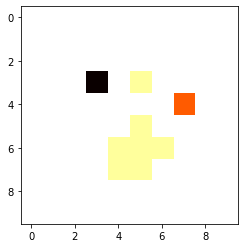

Player: (4,3), Aim: (4,7) 


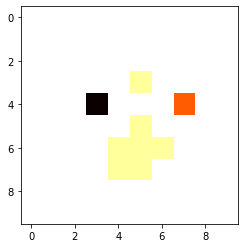

Player: (4,4), Aim: (4,7) 


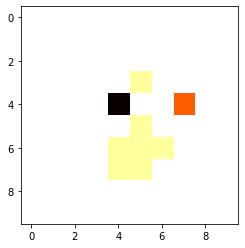

Player: (3,4), Aim: (4,7) 


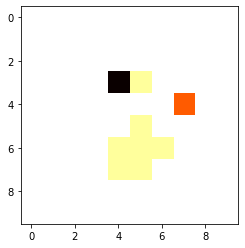

Player: (3,5), Aim: (4,7) 


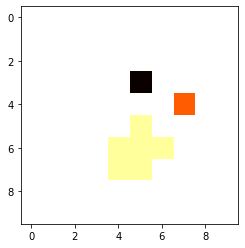

Player: (3,6), Aim: (4,7) 


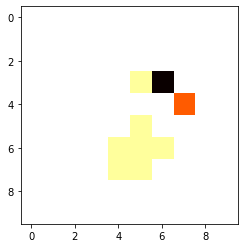

Player: (3,5), Aim: (4,7) 


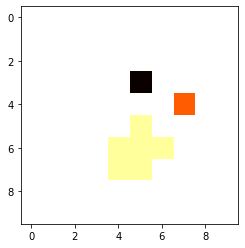

Player: (3,6), Aim: (4,7) 


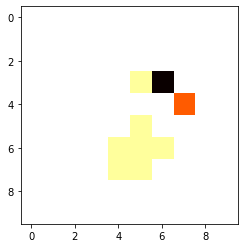

Player: (2,6), Aim: (4,7) 


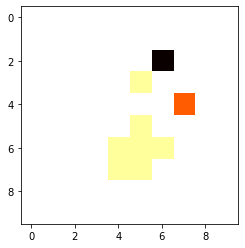

Player: (2,7), Aim: (4,7) 


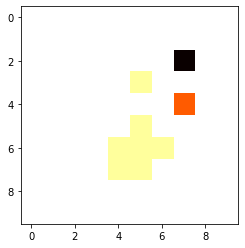

Player: (2,8), Aim: (4,7) 


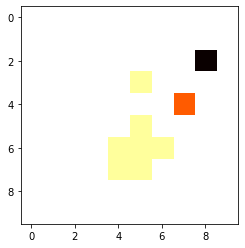

Player: (2,9), Aim: (4,7) 


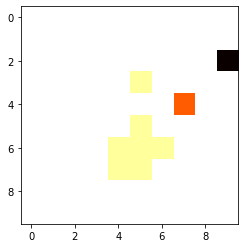

Player: (2,8), Aim: (4,7) 


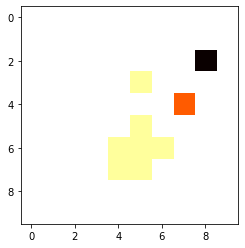

Player: (3,8), Aim: (4,7) 


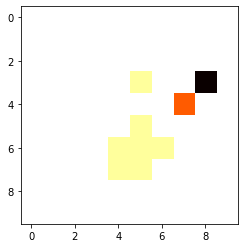

Player: (3,7), Aim: (4,7) 


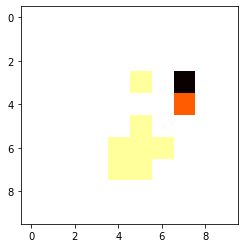

Player: (3,6), Aim: (4,7) 


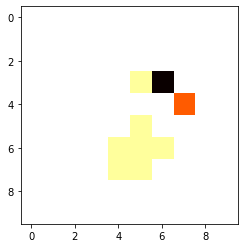

Player: (3,7), Aim: (4,7) 


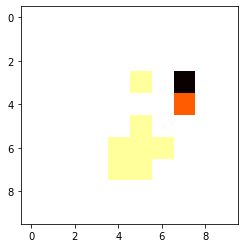

Player: (3,8), Aim: (4,7) 


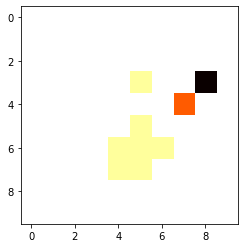

Player: (3,9), Aim: (4,7) 


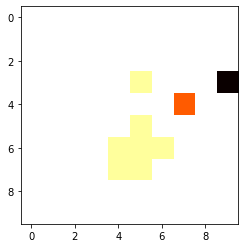

Player: (3,8), Aim: (4,7) 


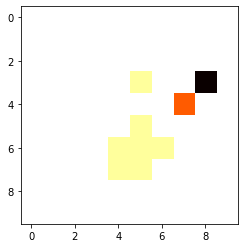

Player: (3,7), Aim: (4,7) 


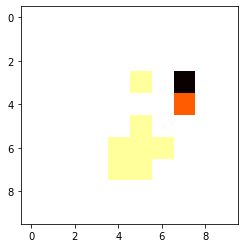

Player: (3,6), Aim: (4,7) 


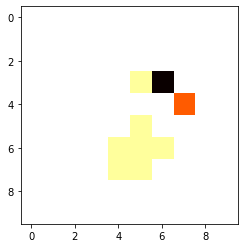

Player: (3,5), Aim: (4,7) 


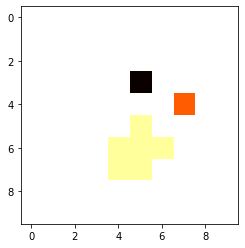

Player: (3,6), Aim: (4,7) 


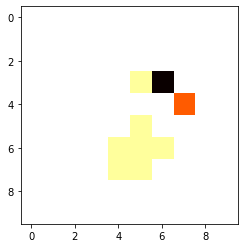

Player: (3,7), Aim: (4,7) 


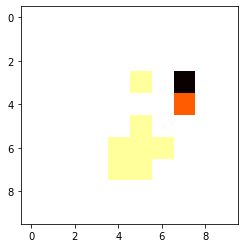

Player: (3,6), Aim: (4,7) 


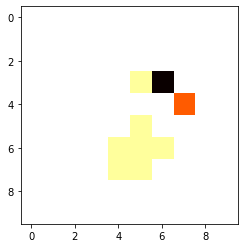

Player: (3,7), Aim: (4,7) 


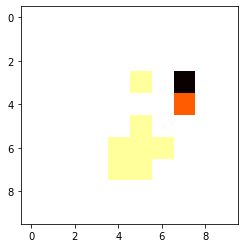

Player: (3,8), Aim: (4,7) 


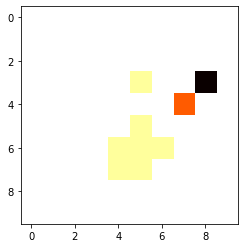

Player: (3,9), Aim: (4,7) 


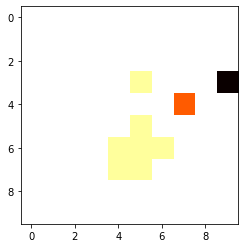

Player: (3,8), Aim: (4,7) 


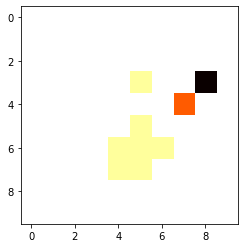

Player: (3,7), Aim: (4,7) 


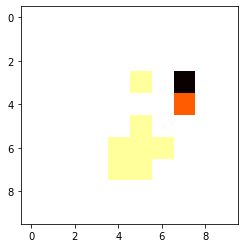

In [73]:
showhist(game_saver[-2])